# [Computational Social Science] Project 4: Unsupervised Learning

Group Number: 

Group Members: 

## Data Description and Preprocessing

For this project, you will explore data from the [National Health and Nutrition Examination Survey](https://www.kaggle.com/cdc/national-health-and-nutrition-examination-survey?select=questionnaire.csv). NHANES is a unique study that combines survey methodology with in-person medical examinations to create a dataset with demographic information, health indicators, and health outcomes.

We start by importing the data and doing some preliminary preprocessing for you. We import some libraries that will be helpful as well. 'SEQN' is the ID number for each respondent, and 'HSD010' will be our target outcome. [HSD010](https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/HSQ_H.htm#HSD010) asks for the respondent's self reported health condition, which can range from "excellent" to "poor."

In [14]:
! pip install keras
! pip install tensorflow

You should consider upgrading via the 'c:\users\peteramerkhanian\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


  Using cached google_auth_oauthlib-0.4.6-py2.py3-none-any.whl (18 kB)
  Using cached pyasn1_modules-0.2.8-py2.py3-none-any.whl (155 kB)
  Using cached pyasn1-0.4.8-py2.py3-none-any.whl (77 kB)
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.10.11
    Uninstalling wrapt-1.10.11:
      Successfully uninstalled wrapt-1.10.11


You should consider upgrading via the 'c:\users\peteramerkhanian\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


In [15]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
sns.set_style("darkgrid")
from sklearn.model_selection import train_test_split

In [16]:
# Load nhanes data
nhanes = pd.read_csv('nhanes.csv')
# Get the ID numbers for each observation (seqn)
seqn = nhanes['SEQN']
# Get the target, "self-reported health condition," HSD010
hsd010 = nhanes['HSD010']
# Drop SEQN from the dataframe and then apply the standard scaler
nhanes = nhanes.drop(['SEQN', 'HSD010'], axis = 1)
nhanes_scaled = pd.DataFrame(StandardScaler().fit_transform(nhanes),
                             columns = nhanes.columns)
# Add the ID and target back in
nhanes_scaled['SEQN'] = seqn
nhanes_scaled['HSD010'] = hsd010
nhanes_scaled = nhanes_scaled.set_index('SEQN')
nhanes_scaled.head()

,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,DR1LANG,DR1MNRSP,DR1HELPD,DBQ095Z,...,OHQ770,OHQ845,PAAQUEX,SMQ860,SMQ870,SMQ872,SMQ874,SMQ878,SMAQUEX.x,HSD010
SEQN,,,,,,,,,,,,,,,,,,,,,
73568,0.0,2.034312,0.0,0.324834,-0.393906,1.085853,-0.194202,-0.057306,0.128246,-0.189513,...,0.383802,-0.646584,-0.484200,1.125008,0.0,-2.081666,1.087115,1.463404,0.612440,1
73576,0.0,0.261930,0.0,-3.078499,0.568251,0.634362,-0.194202,-0.057306,0.128246,0.080373,...,0.383802,-1.539259,-0.484200,1.125008,0.0,-2.081666,1.087115,-0.683338,-1.632812,1
73579,0.0,0.728346,0.0,0.324834,1.530407,-1.623092,-0.194202,-0.057306,0.128246,-0.189513,...,0.383802,-1.539259,2.065262,-0.888883,0.0,0.480384,-0.919866,-0.683338,-1.632812,2
73581,0.0,-0.857470,0.0,0.324834,0.480782,1.085853,-0.194202,-0.057306,0.128246,0.080373,...,0.383802,-0.646584,-0.484200,1.125008,0.0,0.480384,-0.919866,-0.683338,0.612440,2
73584,0.0,0.495138,0.0,0.324834,0.305844,-1.623092,-0.194202,-0.057306,0.128246,0.080373,...,-2.605509,0.246091,2.065262,1.125008,0.0,0.480384,-0.919866,1.463404,-1.632812,3


## Plots

Let's take a look at the data. Below we visualize boxplots of family income to federal poverty line ratio ('INDFMPIR') and self-reported health condition. Notice how there are some clear patterns (the lower the ratio, the lower reported health condition), but it's not a perfect separation. We have 240+ features in our dataset, and we likely have several features in our dataset that highly correlate with our family income-poverty line ratio measure - PCA will help us simplify these.

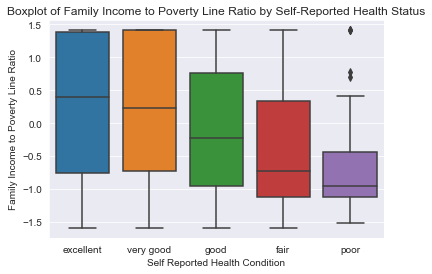

In [17]:
# Create a binary version of hsd010 where 1-3 are "good" and 4-5 are "poor"
nhanes_scaled['HSD010_binary'] = hsd010_binary = nhanes_scaled['HSD010'].replace(
    [1, 2, 3, 4, 5], ['good', 'good', 'good', 'poor', 'poor']) 
# Recode the original hsd010 with the string labels
nhanes_scaled['HSD010'] = nhanes_scaled['HSD010'].replace(
    [1, 2, 3, 4, 5], ['excellent', 'very good', 'good', 'fair', 'poor'])
# Boxplot of hsd010
ax = sns.boxplot(x = 'HSD010', y = 'INDFMPIR', data = nhanes_scaled)
ax.set(xlabel = "Self Reported Health Condition",
      ylabel = "Family Income to Poverty Line Ratio")
ax.set_title("Boxplot of Family Income to Poverty Line Ratio by Self-Reported Health Status")
plt.show()

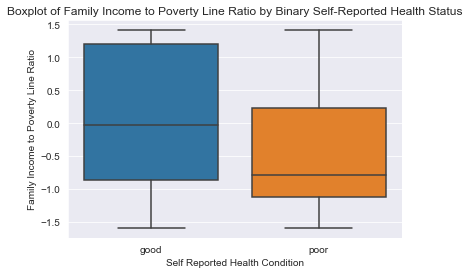

In [18]:
# Boxplot of hsd010_binary
ax = sns.boxplot(x = 'HSD010_binary', y = 'INDFMPIR', data = nhanes_scaled)
ax.set(xlabel = "Self Reported Health Condition",
      ylabel = "Family Income to Poverty Line Ratio")
ax.set_title("Boxplot of Family Income to Poverty Line Ratio by Binary Self-Reported Health Status")
plt.show()

Family income also is not necessarily well correlated with measured health outcomes. See below where we look at the relationship between Body Mass Index (BMI) and the family income-poverty line ratio, and shade points by self-reported health condition. It's hard to find a clear pattern - this is where clustering may come in handy. 

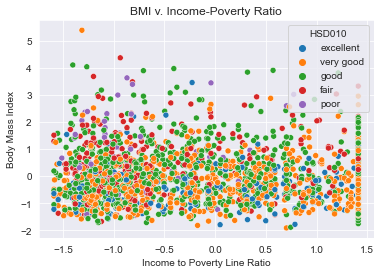

In [19]:
ax = sns.scatterplot(x = "INDFMPIR", y = "BMXBMI", hue = "HSD010", palette = "tab10", data = nhanes_scaled)
ax.set(xlabel = "Income to Poverty Line Ratio",
      ylabel = "Body Mass Index")
ax.set_title("BMI v. Income-Poverty Ratio")
plt.show()

Before we move to working on unsupervised methods, we'll drop our target variables again:

In [20]:
nhanes_scaled = nhanes_scaled.drop(['HSD010', 'HSD010_binary'], axis = 1)

## Principal Component Analysis

Conduct a Principal Component Analysis (PCA) of the nhanes data. The data has already been prepared for you, so you can work directly on nhanes_scaled. Be sure to do the following:

- Choose the number of components and provide 1-2 sentences about your choice of the number of components. 
- Plot a barplot of the variation explained by each component. *Hint*: look at the attributes associated with your model. 
- Choose how many components you will use to fit a supervised learning model and provide 1-2 sentences to explain that choice.
- Plot a 2D scatterplot of the first two components and provide 1-2 sentences analyzing the plot.

### Train PCA and Discuss Number of Components

In [233]:
n_components = 30
# fitting
pca = PCA(n_components=n_components)
principalComponents_nhanes = pca.fit_transform(nhanes_scaled)

# dataframing
pca_columns = [f"PCA{x+1}" for x in np.arange(0, principalComponents_nhanes.shape[1])]
pca_df = pd.DataFrame(principalComponents_nhanes, columns=pca_columns)

# get a look at the explained variances
pca.explained_variance_ratio_

print(f"Proportion of variance explained with {principalComponents_nhanes.shape[1]} components:", 
      round(np.sum(pca.explained_variance_ratio_), 6))

Proportion of variance explained with 30 components: 0.537172


### Barplot of Components

C:\Users\PETERA~2\AppData\Local\Temp/ipykernel_19908/1357715035.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(pca_columns, rotation=90, fontsize=12)


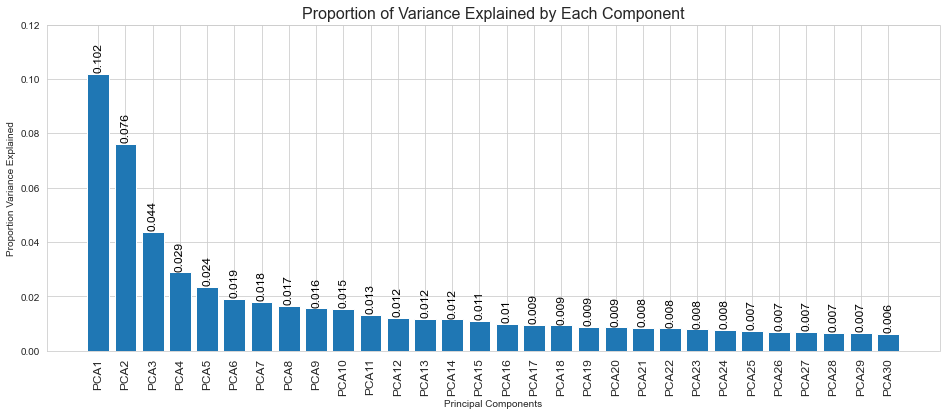

In [234]:
sns.set_style("whitegrid")
gig, ax = plt.subplots(1, 1, figsize=(16, 6))
p = ax.bar(pca_columns, pca.explained_variance_ratio_)
ax.bar_label(p,
             label_type='edge', labels=[round(var_exp, 3) for var_exp in pca.explained_variance_ratio_],
             c="black",
             fontsize=12,
             padding=1.5,
             rotation=90)
ax.set_ylabel("Proportion Variance Explained")
ax.set_xlabel("Principal Components")
ax.set_title("Proportion of Variance Explained by Each Component", fontsize=16)
ax.set_xticklabels(pca_columns, rotation=90, fontsize=12)
ax.set_ylim(0, .12);

### How many components will you use to fit a supervised learning model?

By using `PCA()`'s built in maximum likelihood estimator for choosing the number of components, I found that the optimal choice was 233 components, which described all of the variance in the original data and drops 8 columns. However, in using PCA, I'm hoping to shrink the data much more, so I opt to instead use **30 components**, which only described 54% of the variance in the data, but is much smaller than the original number of columns and so should have considerable computation advantages.

### 2D Scatterplot of the first two components

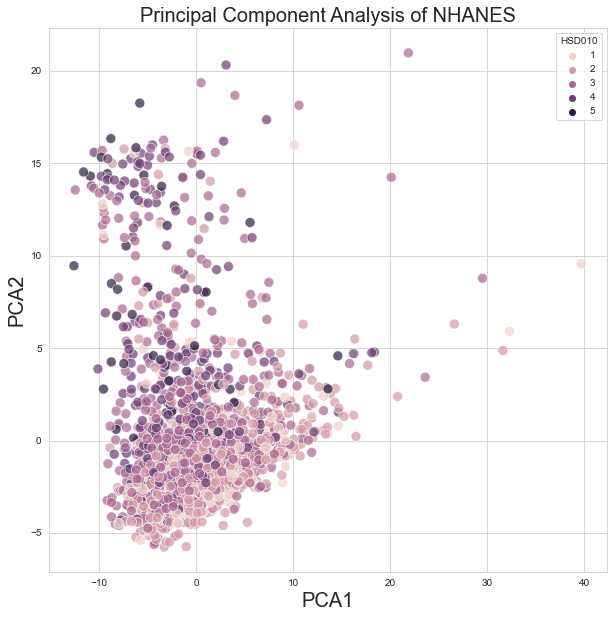

In [235]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.set_xlabel('PCA1',fontsize=20)
ax.set_ylabel('PCA2',fontsize=20)
ax.set_title("Principal Component Analysis of NHANES",fontsize=20)
plotting_df  = pd.concat([pca_df, hsd010], axis=1)
sns.scatterplot(x=plotting_df['PCA1'],
                y=plotting_df['PCA2'],
                hue=plotting_df['HSD010'],
                ax=ax,
                s=100,
                alpha=.7);

## K-Means

- Choose a clustering algorithm and explain it in 1-2 sentences.
- Cluster the nhanes data. Detail any choice you need to make with regards to number of clusters, and how you arrived at that choice. For instance, you might use the [elbow method](https://en.wikipedia.org/wiki/Elbow_method_(clustering) if you choose k-means.
- Plot your clusters on top of BMI v. Income Poverty Ratio Plot. Describe what you see in 1-2 sentences.
- Retrain the clustering algorithm, but this time use your PCA results instead of the original dataframe. Plot the clusters on top of the 2D PCA scatterplot from the previous step. Describe your results in 1-2 sentences.

### Choose a Clustering Algorithm

In [ ]:
## Your Answer Here

### Cluster nhanes

In [ ]:
## Your Answer Here

### Plot your clusters on top of the BMI v. Income Poverty Ratio Plot

In [ ]:
## Your Answer Here

## Your Answer Here

### Retrain the clustering algorithm on PCA components and plot clusters on your 2D scatter

In [ ]:
## Your Answer Here

## Your Answer Here

## Neural Network

Now we are ready to predict! Do the following:

- Choose either HSD010 or HSD010\_binary as your target outcome.  
- Train a neural network using the original features. Much of the code to train a basic neural net has been set up for you, but you will need to fill in a couple of missing pieces.
- Train a neural network using only your PCA components as features.
- Train a neural network using your PCA components and the predicted class membership from your clustering algorithm as features.
- Compare and contrast how well each algorithm did. Which featurization technique would you pick and why?

Below we provide a template for training a neural network. Use this template for training on the original features, on the PCA components, and the PCA components + the predicted classes from your clusters.

### Neural Network on Original Features

In [ ]:
y = ... # either hsd010 or hsd010_binary, may need to convert to numeric if it isn't already 
X = ... # drop out any columns that aren't features

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 10)

In [ ]:
import keras
from keras.utils import np_utils 

num_classes = ...
# convert class vectors to binary class matrices
y_train = np_utils.to_categorical(..., ...)
y_test = np_utils.to_categorical(..., ...)
num_classes = y_test.shape[1]

In [ ]:
model = Sequential()

model.add(
    Dense(..., input_dim= ..., kernel_initializer= ..., activation= ...)
)

model.add(
    Dense(..., kernel_initializer= ..., activation= ...)
)

## Add any additional layers you wish here

model.compile(loss= ..., optimizer= ..., metrics=[...])

model.fit(..., ..., validation_data=(..., ...), epochs=..., batch_size=..., verbose=...)

### Neural Network on Principal Components

In [ ]:
## Your Answer Here

### Neural Network on Principal Components + Cluster Membership

In [ ]:
## Your Answer Here

## Discussion Questions

1. In your own words, what is the difference between PCA and clustering?

## Your Answer Here

2. Did you notice any advantages to combining PCA and clustering? If so, what do you think they were? If not, why do you think you didn't see any gains from this combination?

## Your Answer Here

3. How can unsupervised techniques help with downstream supervised learning tasks when working with "big data?"